# Uncertainty with Bayesian Neural Networks

**Bayesian Neural Networks** (BNN) can be understood as a combination of neural networks and bayesian inference. In traditional deep learning, weights are fixed values (initially random), that we iteratively update via gradient descent. BNN on the other hand learn __distribution parameters over weights__, these distribution parameters are learned using bayesian inference. This approaches allows, among others, to measure uncertainty among predictions.

# Bayesian inference 

In bayesian inference we try to compute $p(w | D_{train})$, the conditional distribution of the weights given the data, aka the *posterior distribution*, rather than static parameters values. 

### Exact Bayesian Inference

Thanks to Bayes' rule we can compute the posterior : 

\begin{align*}
    p(w | D) & = \frac{p(D | w)p(w)}{p(D)}\\
             & = \frac{p(D | w)p(w)}{\int_w' p(D | w')p(w')} \\
\end{align*}

With $\hat{y}$ the predicted output as a function of the input $x$, The posterior distribution over the weights allows us to compute the __predictive distribution__ : 

\begin{align*}
    p(\hat{y}(x) | D) = \int_w p(\hat{y}(x) | w) p(w | D) dw = \mathbb{E}_{p(w | D)} [p(\hat{y}(x) | w)]
\end{align*}

which can be useful to describe the epistemic uncertainty of our model. We will come back later on the uncertainty.

Computing the posterior in this way can be called *exact inference*, and needs the *prior* $p(w)$ and the *likelihood* $p(D | w)$ of the data. Unfortunately in the expression of the posterior and the predictive distribution we need to integrate over the weight space which can be intractable, in order to adresses theses issues we use a set of tools that allow us to do approximate inference. There is two family of approximate inference methods : sampling and variational, we will focus on variational methods.

### Variational inference

The spirit of variational inference is, when facing an intractable posterior $p(w | D)$, to surrogate it with a parametrized distribution $q_{\phi}(w)$, namely the *approximate posterior*. This surrogate distribution will be optimised (by tuning its parameters $\phi$) in order to be as close as possible to the original posterior. In practice the choice of the approximate distribution can be seen as an hyperparameter. Two main questions arise from this : 

* **How to check if the surrogate is close to the true posterior ?** 
* **How to maximize the similarity of our distributions ?**


### Measure of similarity : 

The Kullback-Liebler divergence is a metric that allows us to mesure the similiarity between two distribution. it is defined by the expectation of the log ratio between the two distributions : 

\begin{align*}
    D_{KL}(P \| Q) = \mathbb{E} \left[log \frac{P}{Q}\right]
\end{align*}

in our case : 

\begin{align*}
    D_{KL} (q_{\phi}(w) \| p(w | D)) & = \mathbb{E}_{q_{\phi}(w)}\left[log \frac{q_{\phi}(w)}{p(w |D)} \right] \\
                                    & = \int_w q_\phi (w) log \frac{q_\phi (w)}{p(w |D)}
\end{align*}


The KL divergence is a non-negative measure of similarity, that is 0 for identical distributions
... 

### Derive a tractable optimization problem : 

We have an intractable posterior $p(w | W)$, a surrogate distribution $q_{\phi}(w)$, a way to measure their similarity  $D_{KL} (q_{\phi}(w) \| p(w | D))$, now we need find a way to minimize their dissimilarity. To do this we will formulate it as an optimization problem. 

Directly minimizing  $D_{KL} (q_{\phi}(w) \| p(w | D))$ is 
difficult as $p(w | D)$ is still intractable. To bypass this we will derive a related quantity, equal to the KL divergence plus a constant, that will be our new objective.

\begin{align*}
    D_{KL} (q_{\phi}(w) \| p(w | D)) & = \mathbb{E}_{q_{\phi}(w)}\left[log \frac{q_{\phi}(w)}{p(w |D)} \right] \\
                                     & = \mathbb{E}_{q_{\phi}(w)}\left[log(q_{\phi}(w)) - log (p(w |D)) \right] \\
                                     & = \mathbb{E}_{q_{\phi}(w)}\left[log(q_{\phi}(w))\right] - \mathbb{E}_{q_{\phi}(w)}\left[log (p(D, w)) - log (p(D)) \right] \\        
                                     & = \mathbb{E}_{q_{\phi}(w)}\left[log(q_{\phi}(w))\right] - \mathbb{E}_{q_{\phi}(w)}\left[log (p(D, w))\right] + log p(D)\\                   
\end{align*}

thus 

\begin{align*} 
    log p(D) \geq \mathbb{E}_{q_{\phi}(w)}\left[log q_{\phi}(w) - log p(w, D)\right] \;\;\;\;\;\;\;\; \;\;\;\;\;\;\;\;\; [\small{\text{as}\;\;\; D_{KL}(q \| p) \geq 0}]
\end{align*}

## Make it work with neural networks.
### bayes by backprop

Once our optimization problem formulated we want to be able to optimize it, and in the context of neural networks, using gradient descent. Hence we need a proper algortihm adapted for backpropagation. To do so we will use bayes by backpropagation, a backpropagation compatible algorithm for learning a probability distribution on the weights of a neural network. \cite{Blundell et al.}. 

In bayesian neural networks, it is challenging to differentiate random nodes. To overcome this we will use a tool called the reparametrization trick. Intuitively, the reparametrization trick allows to flow gradient through random nodes by moving the randomness outside of the node, rending it deterministic. As such, backprop can be applied to our variational parameter $\phi$. This gives us the advantage of maintaining a training loop analogous to that of a standard neural network, which is convenient as it permits the use of traditional optimizers, such as Adam.

More formally, considering a gaussian posterior distribution $q_{\phi}(z|x)$, parametrized by $\mu$ and $\sigma$. say we want to minimize a loss function $E_{q_{\phi}(z | x)} [f(z))]$. 
Directly optimizing this expectation with respect to $\phi$ can be difficult due to its randomness in z complicating the computation of gradients. To overcome this we introduce an auxilary variable $\epsilon$ drawn from a distribution $p(\epsilon)$ independent from $\phi$ allowing us to express z as a deterministic function of $\phi$ and $\sigma$ such as $z = g_{\phi}(\epsilon, x) = \mu(x; \mu) + \sigma(w, \phi) \otimes \epsilon$. Typically $\epsilon$ is drawn from Gaussian ditribution $\epsilon \sim \mathcal{N}(0, I)$. Thus the expectation turns into : 

\begin{align*}
    \nabla_{\phi} E_{p(\epsilon)}[f(g_{\phi}(\epsilon, x))] &= E_{p(\epsilon)}[ \nabla_{\phi} f(g_{\phi}(\epsilon, x))] 
\end{align*} 

# Import, data and utils functions 

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout

import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

/tmp/ipykernel_248090/2317591137.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-21 17:37:58.109927: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-21 17:37:58.110015: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-21 17:37:58.114070: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable

# Dataset

- Basic non-linear dataset for a classification problem

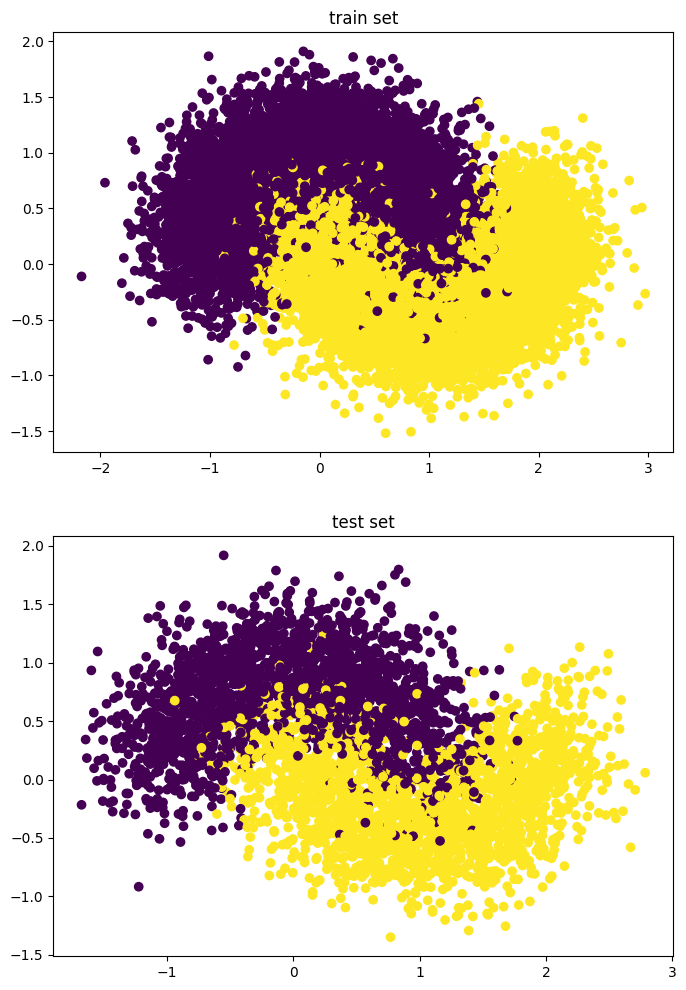

In [2]:
X, y = make_moons(n_samples=20000, noise=0.3)
y = y.reshape(-1,1) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_test = tf.cast(X_test, tf.float32)
X_train = tf.cast(X_train, tf.float32)
y_test = tf.cast(y_test, tf.float32)
y_train = tf.cast(y_train, tf.float32)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))
ax1.scatter(X_train[:,0], X_train[:,1], c=y_train)
ax1.set_title('train set')
ax2.scatter(X_test[:,0], X_test[:,1], c=y_test)
ax2.set_title('test set')

plt.show()

# Baseline model
traditional deep net

In [3]:
def create_network(units=100, activation='relu', lr=0.01) : 
    
    inputs = keras.Input(shape=(X_train.shape[1],))
    
    hidden1 = Dense(units, activation=activation)(inputs)
    hidden1 = BatchNormalization()(hidden1)
    
    hidden2 = Dense(units, activation=activation)(hidden1)
    hidden2 = BatchNormalization()(hidden2)
    
    hidden3 = Dense(units, activation=activation)(hidden2)
    hidden3 = BatchNormalization()(hidden3)
    
    outputs = Dense(1, activation='sigmoid')(hidden3)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name='baseline')

    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['Accuracy'])
    model.summary()
    return model

In [4]:
baseline = create_network()
baseline.fit(X_train, y_train, batch_size=32, verbose=0, epochs=20) 

Model: "baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 100)               300       
                                                                 
 batch_normalization (Batch  (None, 100)               400       
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 batch_normalization_1 (Bat  (None, 100)               400       
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 100)               101

- Evaluate the model

accuracy :  0.91675


Text(0.5, 1.0, 'predictions')

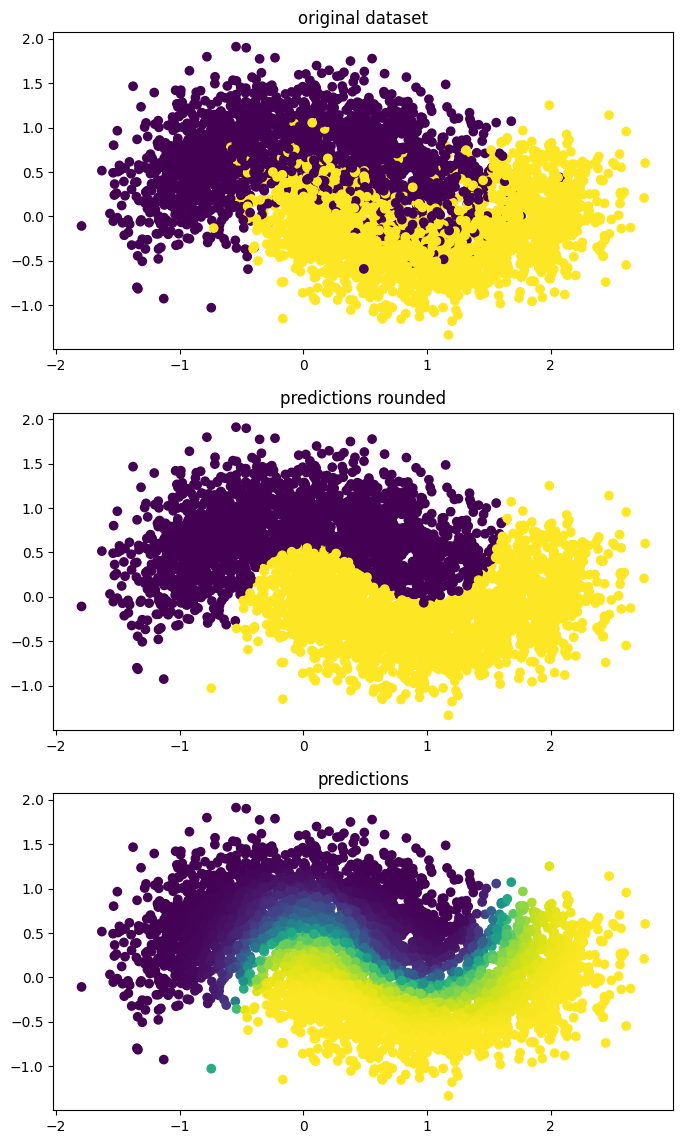

In [5]:
y_pred = np.asarray(baseline(X_test))

print('accuracy : ', accuracy_score(y_test, y_pred.round()))

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(8, 14))
ax1.scatter(X_test[:,0], X_test[:,1], c=y_test)
ax1.set_title('original dataset')

ax2.scatter(X_test[:,0], X_test[:,1], c=y_pred.round())
ax2.set_title('predictions rounded')

ax3.scatter(X_test[:,0], X_test[:,1], c=y_pred)
ax3.set_title('predictions')


* ### Aleatoric uncertainty (aka statistical) : 
Aleatoric uncertainty refers to the notion of randomness, That is the uncertainty rising from the datahimself, where the model cannot act.

To allow a model to capture the aleatoric uncertainty we will output not a point estimate as usual but a probability distribution. In the case of binary classification the output will be a bernoulli distribution. 

$
    \mathbb{P}(X = x) = p^x(1 - p)^{1-x},\;\; x \in [0, 1]
$

As the output is no more a single estimate we need to change the loss function, we will use the **negative loglieklihood**, in order to get how likely it is to encounter targets in our data from the estimated distribution of the model.

In [35]:
def nll(y, y_pred): 
  return -y_pred.log_prob(y)

In practice the only modification to our baseline model is the ouput layer. In our case we will use a *IndependentBernoulli* layer.

In [36]:
def create_aleatoric_model(units=100, activation='relu', lr=0.001):

  inputs = keras.Input(shape=(X_train.shape[1],))

  hidden1 = Dense(units, activation=activation)(inputs)
  hidden1 = BatchNormalization()(hidden1)
  hidden1 = Dropout(0.1)(hidden1)

  hidden2 = Dense(units, activation=activation)(hidden1)
  hidden2 = BatchNormalization()(hidden2)
  hidden2 = Dropout(0.1)(hidden2)
  
  hidden3 = Dense(units, activation=activation)(hidden2)
  hidden3 = BatchNormalization()(hidden3)
  hidden3 = Dropout(0.1)(hidden3)

  # output Bernoulli distribution ! 
  outputs = Dense(tfp.layers.IndependentBernoulli.params_size(1))(hidden3)  
  outputs = tfp.layers.IndependentBernoulli(1)(outputs)

  model = keras.Model(inputs=inputs, outputs=outputs, name='aleatoric_BNN')

  opt = keras.optimizers.Adam(learning_rate=lr)
  model.compile(loss=nll, optimizer=opt, metrics=['Accuracy'])
  model.summary()
  return model

In [37]:
aleatoric_model = create_aleatoric_model()
aleatoric_model.fit(X_train, y_train, batch_size=32, verbose=0, epochs=20) 

Model: "aleatoric_BNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 100)               300       
                                                                 
 batch_normalization (Batch  (None, 100)               400       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 batch_normalization_1 (Bat  (None, 100)               400       
 chNormalization)                                    

**The standard deviation of the outputed distribution will represent te aleatoric uncertainty associated with the dataset :**

accuracy :  0.907


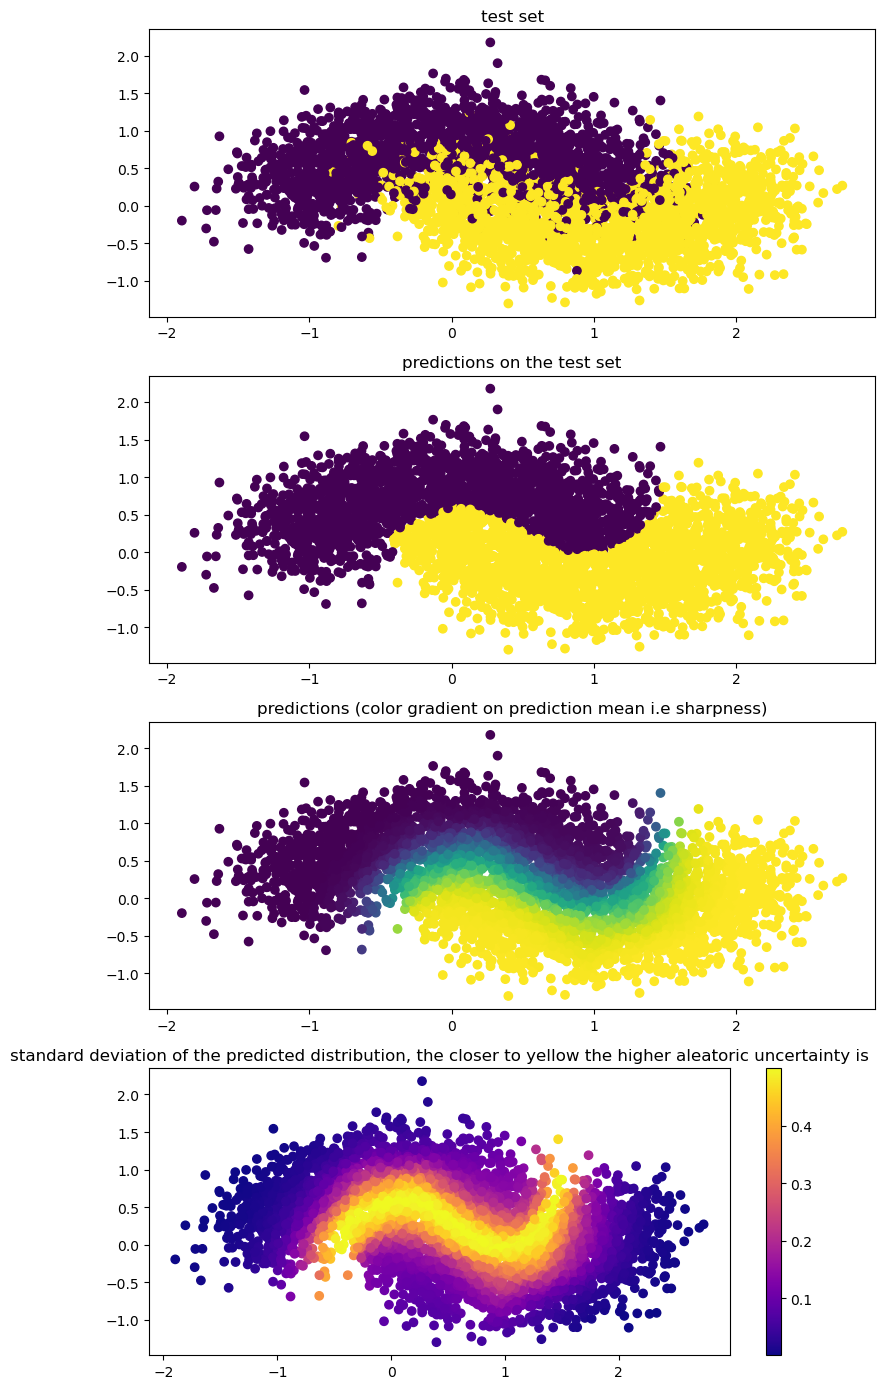

In [38]:
pred_distribution = aleatoric_model(X_test)
pred_mean = pred_distribution.mean().numpy()
pred_stdv = pred_distribution.stddev().numpy()

print('accuracy : ', accuracy_score(y_test, pred_mean.round()))

fig, axs = plt.subplots(4, 1, figsize=(8,14))
axs[0].scatter(X_test[:,0], X_test[:,1], c=y_test)
axs[0].set_title('test set')
axs[1].scatter(X_test[:,0], X_test[:,1], c=pred_mean.round())
axs[1].set_title('predictions on the test set')
axs[2].scatter(X_test[:,0], X_test[:,1], c=pred_mean)
axs[2].set_title('predictions (color gradient on prediction mean i.e sharpness)')
points2 = axs[3].scatter(X_test[:,0], X_test[:,1], c=pred_stdv, cmap='plasma')
axs[3].set_title('standard deviation of the predicted distribution, the closer to yellow the higher aleatoric uncertainty is')

fig.colorbar(points2)

plt.tight_layout()

* ### Epistemic uncertainty (aka systematic) : 
refers to uncertainty caused by a lack of knowledge. It can be seen as the uncertainty of the model itself on his predictions. The epistemic uncertainty is the ability of the model saying 'I don't know'.

In practice, we will use tfp ```DenseVariational``` layers to do variational inference. Recall variational inference relies on Bayesian inference. Thus we need to define a prior $p(w)$ and a posterior distribution $p(w|D)$. The choice of these distributions can be seen as hyperparameters. Prior are imortant as they have a regularization aspect.  Here are listed a few options available with tfp :  

### Priors

* Normal (or Gaussian) prior
  
A basic reasonable approach is a normal prior distribution.  The normal prior acts as a form of regularization, penalizing large weights by making them less probable a priori. This is analogous to L2 regularization (or Ridge regression) in frequentist statistics, where the penalty on the weights is proportional to their squared magnitude.

The normal prior promotes smoothness and smaller magnitudes in the weights but does not explicitly push them to zero. This can lead to models that are less sparse but potentially more stable, as small changes in the input data are less likely to result in large changes in the output.

In [3]:
def normal_prior(kernel_size, bias_size, dtype=None): 
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
    [
          tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=tf.zeros(n),
                       scale=2*tf.ones(n)), 
          reinterpreted_batch_ndims=1)),
    ])
    return prior_model

* Multivariate Normal prior 

As opposed to independent normal priors, where each connexion has its own independent distribution, a mutlivariate normal distribution assigns weights to each neurones of a layer and this thus useful to capture correlation between weights.

In [4]:
def multivariate_normal_prior(kernel_size, bias_size, dtype=None): 
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfd.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model

* Laplace prior

the Laplace prior induces sparsity in a more direct manner. It is analogous to L1 regularization (or the Lasso method) in frequentist statistics.

The Laplace prior encourages sparsity in the model parameters by having a sharp peak at zero and heavy tails. This means that it pushes coefficients towards exactly zero, effectively performing variable selection or feature elimination, which can be beneficial in models with many irrelevant features.

In [5]:
def laplace_prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size # num of params
    return Sequential([
       tfp.layers.DistributionLambda(
           lambda t: tfd.Independent(tfd.Laplace(loc = tf.zeros(n), 
                                                 scale=tf.ones(n)),
                                     reinterpreted_batch_ndims=1))               
  ])

* Horseshoe prior

The Horseshoe prior introduces a form of regularization that is more adaptive compared to traditional techniques like L1 or L2 regularization. It can shrink less relevant weights more aggressively towards zero while allowing important weights to remain large, potentially leading to a more sparse and efficient network. It can be used aswell to prune the network by shifting useless connexions towards 0.

In [6]:
def horseshoe_prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size # num of params
    return Sequential([
       tfp.layers.DistributionLambda(
           lambda t: tfd.Independent(tfd.Horseshoe(scale = tf.zeros(n),
                                                   reinterpreted_batch_ndims=1)))               
  ])

### Posteriors

In variational inference, using a independent normal distribution is a common practice as it ensures mathematical conveniance. They also enable the use of the reparametrization trick, allowing gradient estimations.

In [7]:
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=tf.nn.softplus(t[..., n:])),
          reinterpreted_batch_ndims=1)),
    ])

In [8]:
def posterior(kernel_size, bias_size, dtype=None): 
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    
    return posterior_model

In [9]:
def posterior(kernel_size, bias_size, dtype=None):
  n = kernel_size + bias_size
  posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.IndependentNormal.params_size(n), dtype=dtype
            ),
            tfp.layers.IndependentNormal(n),
        ]
    )
    
  return posterior_model

## Epistemic model

In [11]:
def create_epistemic_model(prior, posterior):
  inputs = keras.Input(shape=(X_train.shape[1],))

  x = tfp.layers.DenseVariational(units=200, 
                                  make_prior_fn=prior,
                                  make_posterior_fn=posterior,
                                  kl_weight = 1 / X_train.shape[0],
                                  activation='relu')(inputs)
  
  x = tfp.layers.DenseVariational(units=200, 
                                  make_prior_fn=prior,
                                  make_posterior_fn=posterior,
                                  kl_weight = 1 / X_train.shape[0],
                                  activation='relu')(x)
                        
  outputs = tfp.layers.DenseVariational(units=1, 
                                  make_prior_fn=prior,
                                  make_posterior_fn=posterior,
                                  kl_weight = 1 / X_train.shape[0],
                                  activation='sigmoid')(x)

  model = keras.Model(inputs=inputs, outputs=outputs, name='epistemic_BNN')

  opt = keras.optimizers.Adam(learning_rate=0.001)

  model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                optimizer=opt, metrics=['Accuracy'])
  model.summary()

  return model

In [12]:
epistemic_model = create_epistemic_model(multivariate_normal_prior, posterior)
epistemic_model.fit(X_train, y_train, batch_size=32, verbose=1, epochs=500) 

Model: "epistemic_BNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_variational (DenseVa  (None, 200)               1200      
 riational)                                                      
                                                                 
 dense_variational_1 (Dense  (None, 200)               80400     
 Variational)                                                    
                                                                 
 dense_variational_2 (Dense  (None, 1)                 402       
 Variational)                                                    
                                                                 
Total params: 82002 (320.32 KB)
Trainable params: 82002 (320.32 KB)
Non-trainable params: 0 (0.00 Byte)
_______________

* TODO remove

In [20]:
epistemic_model.save('./large_epitemic_model')

INFO:tensorflow:Assets written to: ./large_epitemic_model/assets


INFO:tensorflow:Assets written to: ./large_epitemic_model/assets


In [24]:
test = tf.keras.models.load_model('./large_epitemic_model')

In [15]:
def infer(X, y, model_, it=10): 
  y_preds = []
  for _ in range(it): 
    y_preds.append(model_(X))
  
  pred_mean = np.mean(y_preds, axis=0)
  pred_stdv = np.std(y_preds, axis=0)
  
  print('accuracy : ', accuracy_score(y, pred_mean.round()))

  return pred_mean, pred_stdv

accuracy :  0.9135


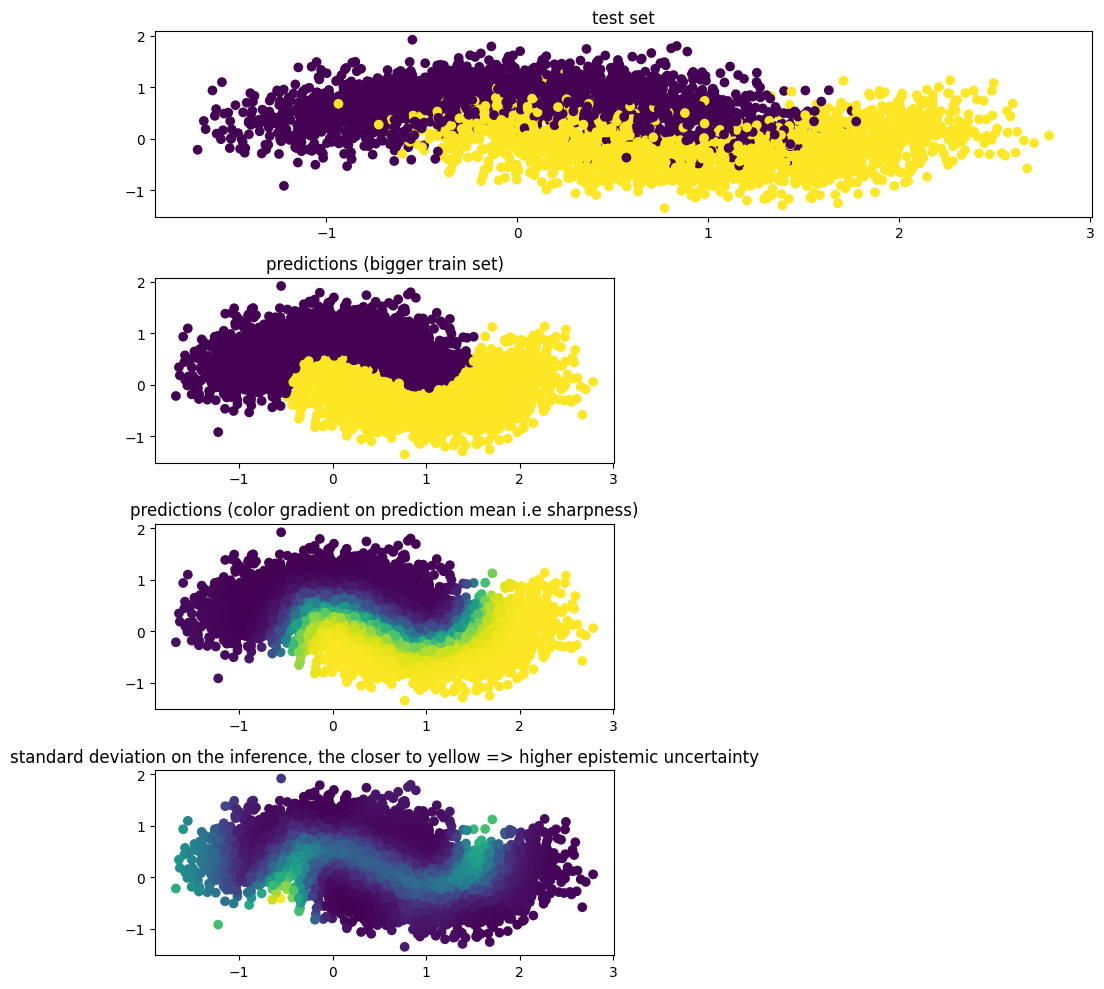

In [27]:
pred_mean, pred_stdv = infer(X_test, y_test, epistemic_model, 100) 

fig = plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.scatter(X_test[:,0], X_test[:,1], c=y_test)
plt.title('test set')

plt.subplot(4,2,3)
plt.scatter(X_test[:,0], X_test[:,1], c=pred_mean.round())
plt.title('predictions (bigger train set)')

plt.subplot(4,2,5)
plt.scatter(X_test[:,0], X_test[:,1], c=pred_mean)
plt.title('predictions (color gradient on prediction mean i.e sharpness)')

plt.subplot(4,2,7)
plt.scatter(X_test[:,0], X_test[:,1], c=pred_stdv)
plt.title('standard deviation on the inference, the closer to yellow => higher epistemic uncertainty')

plt.tight_layout()


In [ ]:
small_epistemic_model = create_epistemic_model(multivariate_normal_prior, posterior)
small_epistemic_model.fit(X_train[:1000], y_train[:1000], batch_size=32, verbose=1, epochs=4000) 

Model: "epistemic_BNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_variational_15 (Dens  (None, 200)               1200      
 eVariational)                                                   
                                                                 
 dense_variational_16 (Dens  (None, 200)               80400     
 eVariational)                                                   
                                                                 
 dense_variational_17 (Dens  (None, 1)                 402       
 eVariational)                                                   
                                                                 
Total params: 82002 (320.32 KB)
Trainable params: 82002 (320.32 KB)
Non-trainable params: 0 (0.00 Byte)
_______________

Text(0.5, 1.0, 'small train set')

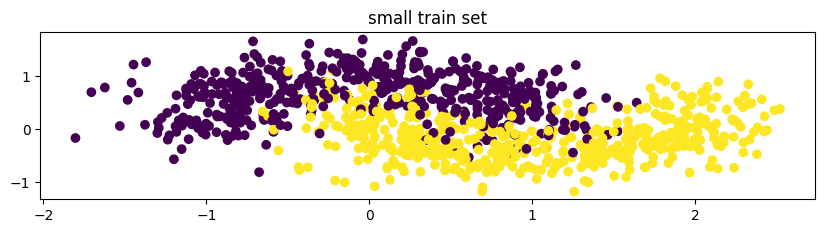

In [41]:
#subset
fig = plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.scatter(X_train[:1000,0], X_train[:1000,1], c=y_train[:1000])
plt.title('small train set')


accuracy :  0.9125


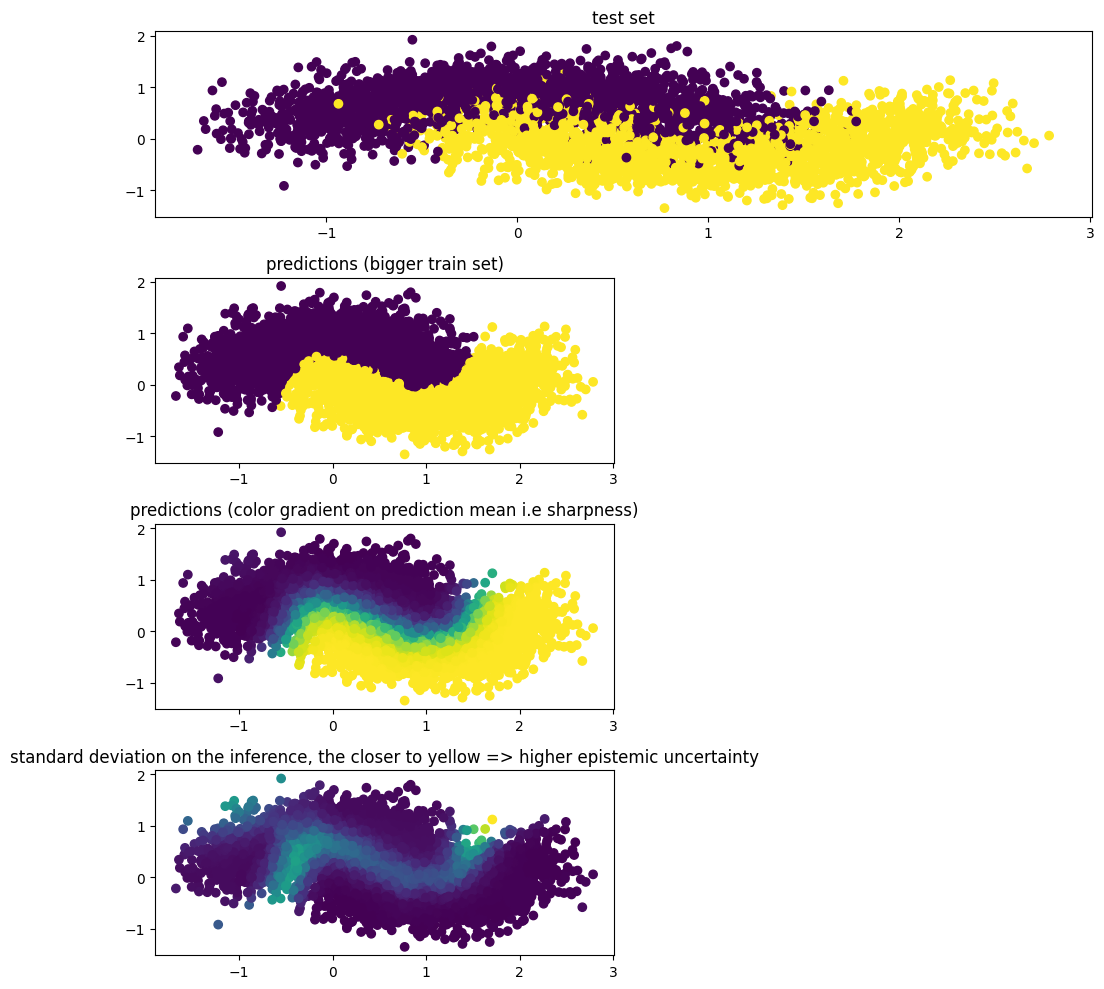

In [37]:
pred_mean, pred_stdv = infer(X_test, y_test, small_epistemic_model, 10) 

fig = plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.scatter(X_test[:,0], X_test[:,1], c=y_test)
plt.title('test set')

plt.subplot(4,2,3)
plt.scatter(X_test[:,0], X_test[:,1], c=pred_mean.round())
plt.title('predictions (bigger train set)')

plt.subplot(4,2,5)
plt.scatter(X_test[:,0], X_test[:,1], c=pred_mean)
plt.title('predictions (color gradient on prediction mean i.e sharpness)')

plt.subplot(4,2,7)
plt.scatter(X_test[:,0], X_test[:,1], c=pred_stdv)
plt.title('standard deviation on the inference, the closer to yellow => higher epistemic uncertainty')

plt.tight_layout()


## Epistemic regression

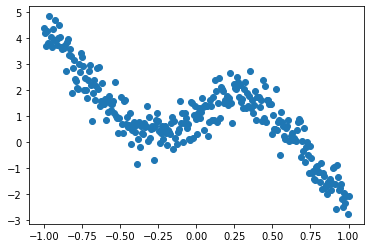

In [217]:
X = np.linspace(-1, 1, 300)
y = 4 * X * np.cos(np.pi * np.sin(X)) + 1 + np.random.randn(X.shape[0]) * 0.5
plt.scatter(X, y)

In [200]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(225,) (75,)
(225,) (75,)


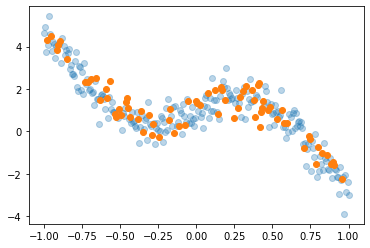

In [371]:
plt.scatter(X_train, y_train, alpha=0.3)
plt.scatter(X_test, y_test)

In [103]:
# Prior is not trainable
def prior(kernel_size, bias_size, dtype = None):
    n = kernel_size + bias_size # num of params
    return Sequential([
       tfp.layers.DistributionLambda(
           lambda t: tfd.Laplace(loc = tf.zeros(n), scale= 2 * tf.ones(n))
       )                     
  ])

def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(

          tfd.Normal(loc=t[..., :n],
                     scale= 1e-5 + 0.003 * tf.nn.softplus(t[..., n:])),
          reinterpreted_batch_ndims=1)),
    ])

In [203]:
def epistemic_regressor():
  inputs = keras.Input(shape=(1,))

  x = tfp.layers.DenseVariational(units=128, 
                                  make_prior_fn=prior,
                                  make_posterior_fn=posterior,
                                  kl_weight = 1 / X_train.shape[0],
                                  activation='relu')(inputs)
  
  x = tfp.layers.DenseVariational(units=64, 
                                  make_prior_fn=prior,
                                  make_posterior_fn=posterior,
                                  kl_weight = 1 / X_train.shape[0],
                                  activation='relu')(x)
                    
  outputs = tfp.layers.DenseVariational(units=1, 
                                  make_prior_fn=prior,
                                  make_posterior_fn=posterior,
                                  kl_weight = 1 / X_train.shape[0])(x)

  model = keras.Model(inputs=inputs, outputs=outputs, name='epistemic_BNN')

  opt = keras.optimizers.Adam(learning_rate=0.001)

  model.compile(loss='mse', optimizer=opt)
  model.summary()

  return model
  

In [202]:
def train_regressor(X_train, X_test, y_train, y_test, model, epochs=100, batch_size=32, verbose=0):
  device_name = tf.test.gpu_device_name()
  if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
  else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

  with tf.device(device_name):
    model.fit(X_train, y_train, batch_size=batch_size, verbose=verbose, epochs=epochs, 
                                validation_data=(X_test, y_test),) 
    
    
  return model 

In [205]:
regressor = epistemic_regressor()
regressor = train_regressor(X_train, X_test, y_train, y_test, regressor, verbose=1, epochs=2000)

Model: "epistemic_BNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 1)]               0         
                                                                 
 dense_variational_10 (Dense  (None, 128)              512       
 Variational)                                                    
                                                                 
 dense_variational_11 (Dense  (None, 64)               16512     
 Variational)                                                    
                                                                 
 dense_variational_12 (Dense  (None, 1)                130       
 Variational)                                                    
                                                                 
Total params: 17,154
Trainable params: 17,154
Non-trainable params: 0
_________________________________________________

8/8 [==============================] - 0s 4ms/step - loss: 1243050.3750 - val_loss: 1241332.2500
Epoch 138/2000
8/8 [==============================] - 0s 4ms/step - loss: 1240920.0000 - val_loss: 1242470.0000
Epoch 139/2000
8/8 [==============================] - 0s 4ms/step - loss: 1241562.5000 - val_loss: 1238588.2500
Epoch 140/2000
8/8 [==============================] - 0s 4ms/step - loss: 1238054.1250 - val_loss: 1238285.5000
Epoch 141/2000
8/8 [==============================] - 0s 4ms/step - loss: 1238738.2500 - val_loss: 1235728.0000
Epoch 142/2000
8/8 [==============================] - 0s 4ms/step - loss: 1236759.6250 - val_loss: 1237192.3750
Epoch 143/2000
8/8 [==============================] - 0s 4ms/step - loss: 1236092.0000 - val_loss: 1233981.8750
Epoch 144/2000
8/8 [==============================] - 0s 4ms/step - loss: 1233634.0000 - val_loss: 1234341.7500
Epoch 145/2000
8/8 [==============================] - 0s 4ms/step - loss: 1234802.3750 - val_loss: 1231456.3750
Epoch 1

8/8 [==============================] - 0s 4ms/step - loss: 1100497.1250 - val_loss: 1097284.0000
Epoch 284/2000
8/8 [==============================] - 0s 4ms/step - loss: 1100528.3750 - val_loss: 1097513.5000
Epoch 285/2000
8/8 [==============================] - 0s 4ms/step - loss: 1098104.5000 - val_loss: 1095923.0000
Epoch 286/2000
8/8 [==============================] - 0s 4ms/step - loss: 1097462.0000 - val_loss: 1097005.7500
Epoch 287/2000
8/8 [==============================] - 0s 4ms/step - loss: 1097111.2500 - val_loss: 1093925.3750
Epoch 288/2000
8/8 [==============================] - 0s 4ms/step - loss: 1095082.1250 - val_loss: 1094128.0000
Epoch 289/2000
8/8 [==============================] - 0s 4ms/step - loss: 1093357.8750 - val_loss: 1092120.3750
Epoch 290/2000
8/8 [==============================] - 0s 4ms/step - loss: 1093928.0000 - val_loss: 1093034.8750
Epoch 291/2000
8/8 [==============================] - 0s 4ms/step - loss: 1092891.6250 - val_loss: 1091100.0000
Epoch 2

8/8 [==============================] - 0s 4ms/step - loss: 996702.0625 - val_loss: 998554.8750
Epoch 430/2000
8/8 [==============================] - 0s 4ms/step - loss: 997825.4375 - val_loss: 998688.6250
Epoch 431/2000
8/8 [==============================] - 0s 4ms/step - loss: 997623.6875 - val_loss: 998320.1875
Epoch 432/2000
8/8 [==============================] - 0s 4ms/step - loss: 994709.8750 - val_loss: 993243.8125
Epoch 433/2000
8/8 [==============================] - 0s 4ms/step - loss: 994788.2500 - val_loss: 993552.4375
Epoch 434/2000
8/8 [==============================] - 0s 4ms/step - loss: 993193.2500 - val_loss: 994893.7500
Epoch 435/2000
8/8 [==============================] - 0s 4ms/step - loss: 994514.7500 - val_loss: 994087.0625
Epoch 436/2000
8/8 [==============================] - 0s 4ms/step - loss: 993330.7500 - val_loss: 993710.3750
Epoch 437/2000
8/8 [==============================] - 0s 4ms/step - loss: 993472.1250 - val_loss: 991545.5000
Epoch 438/2000
8/8 [=====

8/8 [==============================] - 0s 4ms/step - loss: 918858.8750 - val_loss: 916156.0625
Epoch 578/2000
8/8 [==============================] - 0s 4ms/step - loss: 917322.3750 - val_loss: 919258.0000
Epoch 579/2000
8/8 [==============================] - 0s 4ms/step - loss: 917082.9375 - val_loss: 915428.9375
Epoch 580/2000
8/8 [==============================] - 0s 4ms/step - loss: 915553.0000 - val_loss: 914668.9375
Epoch 581/2000
8/8 [==============================] - 0s 4ms/step - loss: 914881.2500 - val_loss: 917174.5000
Epoch 582/2000
8/8 [==============================] - 0s 4ms/step - loss: 915740.8750 - val_loss: 917185.9375
Epoch 583/2000
8/8 [==============================] - 0s 4ms/step - loss: 915946.1250 - val_loss: 914638.3125
Epoch 584/2000
8/8 [==============================] - 0s 4ms/step - loss: 915846.5000 - val_loss: 913551.0625
Epoch 585/2000
8/8 [==============================] - 0s 4ms/step - loss: 913335.6875 - val_loss: 912751.2500
Epoch 586/2000
8/8 [=====

8/8 [==============================] - 0s 4ms/step - loss: 853174.8125 - val_loss: 852823.1250
Epoch 726/2000
8/8 [==============================] - 0s 4ms/step - loss: 852670.2500 - val_loss: 850248.8750
Epoch 727/2000
8/8 [==============================] - 0s 4ms/step - loss: 853051.8750 - val_loss: 853064.4375
Epoch 728/2000
8/8 [==============================] - 0s 4ms/step - loss: 852791.5625 - val_loss: 851500.5625
Epoch 729/2000
8/8 [==============================] - 0s 4ms/step - loss: 851106.5625 - val_loss: 849323.0625
Epoch 730/2000
8/8 [==============================] - 0s 4ms/step - loss: 851124.9375 - val_loss: 853640.3125
Epoch 731/2000
8/8 [==============================] - 0s 4ms/step - loss: 850333.8750 - val_loss: 849278.7500
Epoch 732/2000
8/8 [==============================] - 0s 4ms/step - loss: 851893.5625 - val_loss: 848982.7500
Epoch 733/2000
8/8 [==============================] - 0s 4ms/step - loss: 849629.3125 - val_loss: 848858.5625
Epoch 734/2000
8/8 [=====

8/8 [==============================] - 0s 4ms/step - loss: 796931.0625 - val_loss: 799169.9375
Epoch 874/2000
8/8 [==============================] - 0s 4ms/step - loss: 799409.8750 - val_loss: 795235.8125
Epoch 875/2000
8/8 [==============================] - 0s 4ms/step - loss: 797552.0000 - val_loss: 796991.1250
Epoch 876/2000
8/8 [==============================] - 0s 4ms/step - loss: 797941.0625 - val_loss: 797459.0000
Epoch 877/2000
8/8 [==============================] - 0s 4ms/step - loss: 796578.3750 - val_loss: 797363.2500
Epoch 878/2000
8/8 [==============================] - 0s 4ms/step - loss: 798072.5625 - val_loss: 794705.5000
Epoch 879/2000
8/8 [==============================] - 0s 4ms/step - loss: 796732.0000 - val_loss: 794900.4375
Epoch 880/2000
8/8 [==============================] - 0s 4ms/step - loss: 795751.8125 - val_loss: 797483.0000
Epoch 881/2000
8/8 [==============================] - 0s 4ms/step - loss: 797609.9375 - val_loss: 795519.0625
Epoch 882/2000
8/8 [=====

8/8 [==============================] - 0s 4ms/step - loss: 750508.4375 - val_loss: 753044.2500
Epoch 1022/2000
8/8 [==============================] - 0s 4ms/step - loss: 751190.0000 - val_loss: 753590.8750
Epoch 1023/2000
8/8 [==============================] - 0s 4ms/step - loss: 749881.6875 - val_loss: 749289.0000
Epoch 1024/2000
8/8 [==============================] - 0s 4ms/step - loss: 750117.6875 - val_loss: 749043.8125
Epoch 1025/2000
8/8 [==============================] - 0s 4ms/step - loss: 748805.6250 - val_loss: 751067.6250
Epoch 1026/2000
8/8 [==============================] - 0s 4ms/step - loss: 749093.2500 - val_loss: 749518.3750
Epoch 1027/2000
8/8 [==============================] - 0s 4ms/step - loss: 748860.5625 - val_loss: 747959.9375
Epoch 1028/2000
8/8 [==============================] - 0s 4ms/step - loss: 747814.0000 - val_loss: 750259.8125
Epoch 1029/2000
8/8 [==============================] - 0s 4ms/step - loss: 749199.3125 - val_loss: 747686.7500
Epoch 1030/2000
8

Epoch 1095/2000
8/8 [==============================] - 0s 4ms/step - loss: 729744.0625 - val_loss: 730731.8125
Epoch 1096/2000
8/8 [==============================] - 0s 4ms/step - loss: 729014.5000 - val_loss: 730090.1875
Epoch 1097/2000
8/8 [==============================] - 0s 4ms/step - loss: 727920.6250 - val_loss: 727128.8125
Epoch 1098/2000
8/8 [==============================] - 0s 4ms/step - loss: 727261.1250 - val_loss: 728624.9375
Epoch 1099/2000
8/8 [==============================] - 0s 4ms/step - loss: 727598.3750 - val_loss: 727253.5000
Epoch 1100/2000
8/8 [==============================] - 0s 4ms/step - loss: 727323.3750 - val_loss: 726691.1875
Epoch 1101/2000
8/8 [==============================] - 0s 4ms/step - loss: 728786.6250 - val_loss: 726740.1250
Epoch 1102/2000
8/8 [==============================] - 0s 4ms/step - loss: 726492.8750 - val_loss: 725635.0000
Epoch 1103/2000
8/8 [==============================] - 0s 4ms/step - loss: 726547.1875 - val_loss: 728471.8125
E

Epoch 1169/2000
8/8 [==============================] - 0s 4ms/step - loss: 708230.2500 - val_loss: 707785.6250
Epoch 1170/2000
8/8 [==============================] - 0s 4ms/step - loss: 709618.8750 - val_loss: 711527.1250
Epoch 1171/2000
8/8 [==============================] - 0s 4ms/step - loss: 708570.6875 - val_loss: 706641.5625
Epoch 1172/2000
8/8 [==============================] - 0s 4ms/step - loss: 708616.1250 - val_loss: 703705.0625
Epoch 1173/2000
8/8 [==============================] - 0s 4ms/step - loss: 707843.7500 - val_loss: 707953.8125
Epoch 1174/2000
8/8 [==============================] - 0s 4ms/step - loss: 706221.7500 - val_loss: 706504.5625
Epoch 1175/2000
8/8 [==============================] - 0s 4ms/step - loss: 707639.8125 - val_loss: 708819.0625
Epoch 1176/2000
8/8 [==============================] - 0s 4ms/step - loss: 707712.9375 - val_loss: 707345.8125
Epoch 1177/2000
8/8 [==============================] - 0s 4ms/step - loss: 707869.3750 - val_loss: 707547.3750
E

Epoch 1243/2000
8/8 [==============================] - 0s 4ms/step - loss: 689746.5000 - val_loss: 690704.1875
Epoch 1244/2000
8/8 [==============================] - 0s 4ms/step - loss: 689588.7500 - val_loss: 687777.0000
Epoch 1245/2000
8/8 [==============================] - 0s 4ms/step - loss: 690047.6250 - val_loss: 690014.1250
Epoch 1246/2000
8/8 [==============================] - 0s 4ms/step - loss: 688976.4375 - val_loss: 687990.5625
Epoch 1247/2000
8/8 [==============================] - 0s 4ms/step - loss: 686939.3125 - val_loss: 688539.6875
Epoch 1248/2000
8/8 [==============================] - 0s 4ms/step - loss: 685912.6875 - val_loss: 684986.5625
Epoch 1249/2000
8/8 [==============================] - 0s 4ms/step - loss: 687881.1875 - val_loss: 688477.4375
Epoch 1250/2000
8/8 [==============================] - 0s 4ms/step - loss: 688180.2500 - val_loss: 688814.5625
Epoch 1251/2000
8/8 [==============================] - 0s 4ms/step - loss: 687167.5625 - val_loss: 687571.8125
E

Epoch 1317/2000
8/8 [==============================] - 0s 4ms/step - loss: 671153.1875 - val_loss: 674043.8125
Epoch 1318/2000
8/8 [==============================] - 0s 4ms/step - loss: 670714.6875 - val_loss: 671751.0625
Epoch 1319/2000
8/8 [==============================] - 0s 4ms/step - loss: 671698.2500 - val_loss: 671379.5000
Epoch 1320/2000
8/8 [==============================] - 0s 4ms/step - loss: 671379.1250 - val_loss: 667670.6250
Epoch 1321/2000
8/8 [==============================] - 0s 4ms/step - loss: 670396.3750 - val_loss: 668743.8125
Epoch 1322/2000
8/8 [==============================] - 0s 4ms/step - loss: 670336.8750 - val_loss: 671471.6250
Epoch 1323/2000
8/8 [==============================] - 0s 4ms/step - loss: 669397.6875 - val_loss: 667901.2500
Epoch 1324/2000
8/8 [==============================] - 0s 4ms/step - loss: 667884.2500 - val_loss: 671810.3125
Epoch 1325/2000
8/8 [==============================] - 0s 4ms/step - loss: 669272.6250 - val_loss: 668258.5000
E

Epoch 1391/2000
8/8 [==============================] - 0s 4ms/step - loss: 653367.8750 - val_loss: 652151.5625
Epoch 1392/2000
8/8 [==============================] - 0s 4ms/step - loss: 652317.4375 - val_loss: 652237.5625
Epoch 1393/2000
8/8 [==============================] - 0s 4ms/step - loss: 655852.5000 - val_loss: 652950.1875
Epoch 1394/2000
8/8 [==============================] - 0s 4ms/step - loss: 651222.3125 - val_loss: 652913.0000
Epoch 1395/2000
8/8 [==============================] - 0s 4ms/step - loss: 652086.5000 - val_loss: 653962.7500
Epoch 1396/2000
8/8 [==============================] - 0s 4ms/step - loss: 651383.1875 - val_loss: 652008.8750
Epoch 1397/2000
8/8 [==============================] - 0s 4ms/step - loss: 651682.0625 - val_loss: 652557.8750
Epoch 1398/2000
8/8 [==============================] - 0s 4ms/step - loss: 651591.9375 - val_loss: 650373.1875
Epoch 1399/2000
8/8 [==============================] - 0s 4ms/step - loss: 651791.3750 - val_loss: 651272.1875
E

Epoch 1465/2000
8/8 [==============================] - 0s 4ms/step - loss: 637386.0000 - val_loss: 635547.7500
Epoch 1466/2000
8/8 [==============================] - 0s 4ms/step - loss: 637163.5000 - val_loss: 640048.0625
Epoch 1467/2000
8/8 [==============================] - 0s 4ms/step - loss: 635369.7500 - val_loss: 638938.7500
Epoch 1468/2000
8/8 [==============================] - 0s 4ms/step - loss: 637350.3750 - val_loss: 636556.9375
Epoch 1469/2000
8/8 [==============================] - 0s 4ms/step - loss: 636892.5625 - val_loss: 636307.9375
Epoch 1470/2000
8/8 [==============================] - 0s 4ms/step - loss: 635735.4375 - val_loss: 637155.8125
Epoch 1471/2000
8/8 [==============================] - 0s 4ms/step - loss: 636653.5625 - val_loss: 633044.7500
Epoch 1472/2000
8/8 [==============================] - 0s 4ms/step - loss: 635520.8125 - val_loss: 637610.1250
Epoch 1473/2000
8/8 [==============================] - 0s 4ms/step - loss: 635624.8750 - val_loss: 634857.6250
E

Epoch 1539/2000
8/8 [==============================] - 0s 4ms/step - loss: 619249.5625 - val_loss: 623471.0625
Epoch 1540/2000
8/8 [==============================] - 0s 4ms/step - loss: 622468.1875 - val_loss: 620635.3125
Epoch 1541/2000
8/8 [==============================] - 0s 4ms/step - loss: 621292.8750 - val_loss: 621386.8750
Epoch 1542/2000
8/8 [==============================] - 0s 4ms/step - loss: 620376.5625 - val_loss: 620108.5625
Epoch 1543/2000
8/8 [==============================] - 0s 4ms/step - loss: 619203.4375 - val_loss: 618885.4375
Epoch 1544/2000
8/8 [==============================] - 0s 4ms/step - loss: 621108.6250 - val_loss: 620712.3125
Epoch 1545/2000
8/8 [==============================] - 0s 4ms/step - loss: 619300.0625 - val_loss: 620970.3125
Epoch 1546/2000
8/8 [==============================] - 0s 4ms/step - loss: 619666.3750 - val_loss: 618763.0000
Epoch 1547/2000
8/8 [==============================] - 0s 4ms/step - loss: 618669.6250 - val_loss: 618335.3750
E

Epoch 1613/2000
8/8 [==============================] - 0s 4ms/step - loss: 606600.7500 - val_loss: 603659.0625
Epoch 1614/2000
8/8 [==============================] - 0s 4ms/step - loss: 608369.4375 - val_loss: 606744.8125
Epoch 1615/2000
8/8 [==============================] - 0s 4ms/step - loss: 605320.3125 - val_loss: 602264.3125
Epoch 1616/2000
8/8 [==============================] - 0s 4ms/step - loss: 605480.8750 - val_loss: 606040.6875
Epoch 1617/2000
8/8 [==============================] - 0s 4ms/step - loss: 604412.1875 - val_loss: 603235.7500
Epoch 1618/2000
8/8 [==============================] - 0s 4ms/step - loss: 604028.0000 - val_loss: 606080.5625
Epoch 1619/2000
8/8 [==============================] - 0s 4ms/step - loss: 603964.8125 - val_loss: 606047.4375
Epoch 1620/2000
8/8 [==============================] - 0s 4ms/step - loss: 603783.9375 - val_loss: 606182.6875
Epoch 1621/2000
8/8 [==============================] - 0s 4ms/step - loss: 602772.0000 - val_loss: 605265.3125
E

Epoch 1687/2000
8/8 [==============================] - 0s 4ms/step - loss: 590786.1250 - val_loss: 590266.6250
Epoch 1688/2000
8/8 [==============================] - 0s 4ms/step - loss: 591106.1875 - val_loss: 590366.6875
Epoch 1689/2000
8/8 [==============================] - 0s 4ms/step - loss: 590575.4375 - val_loss: 593435.5625
Epoch 1690/2000
8/8 [==============================] - 0s 4ms/step - loss: 592015.0000 - val_loss: 590436.6250
Epoch 1691/2000
8/8 [==============================] - 0s 4ms/step - loss: 589963.0625 - val_loss: 590862.8750
Epoch 1692/2000
8/8 [==============================] - 0s 4ms/step - loss: 589451.5000 - val_loss: 588554.8125
Epoch 1693/2000
8/8 [==============================] - 0s 4ms/step - loss: 589950.3125 - val_loss: 592740.1250
Epoch 1694/2000
8/8 [==============================] - 0s 4ms/step - loss: 589885.8750 - val_loss: 590096.8750
Epoch 1695/2000
8/8 [==============================] - 0s 4ms/step - loss: 589655.8125 - val_loss: 587964.1875
E

Epoch 1761/2000
8/8 [==============================] - 0s 4ms/step - loss: 576306.6250 - val_loss: 576664.1250
Epoch 1762/2000
8/8 [==============================] - 0s 4ms/step - loss: 577105.4375 - val_loss: 577484.8125
Epoch 1763/2000
8/8 [==============================] - 0s 4ms/step - loss: 576837.5000 - val_loss: 576796.6250
Epoch 1764/2000
8/8 [==============================] - 0s 4ms/step - loss: 576990.6250 - val_loss: 577447.9375
Epoch 1765/2000
8/8 [==============================] - 0s 4ms/step - loss: 576647.7500 - val_loss: 577576.1875
Epoch 1766/2000
8/8 [==============================] - 0s 4ms/step - loss: 576674.5000 - val_loss: 575671.0000
Epoch 1767/2000
8/8 [==============================] - 0s 4ms/step - loss: 575940.5625 - val_loss: 575026.7500
Epoch 1768/2000
8/8 [==============================] - 0s 4ms/step - loss: 575004.9375 - val_loss: 573340.6875
Epoch 1769/2000
8/8 [==============================] - 0s 4ms/step - loss: 575943.4375 - val_loss: 574569.6250
E

Epoch 1835/2000
8/8 [==============================] - 0s 4ms/step - loss: 563635.5625 - val_loss: 567140.1875
Epoch 1836/2000
8/8 [==============================] - 0s 4ms/step - loss: 563307.9375 - val_loss: 562122.7500
Epoch 1837/2000
8/8 [==============================] - 0s 4ms/step - loss: 563907.0625 - val_loss: 559996.8125
Epoch 1838/2000
8/8 [==============================] - 0s 4ms/step - loss: 564540.1875 - val_loss: 564405.5000
Epoch 1839/2000
8/8 [==============================] - 0s 4ms/step - loss: 564496.8750 - val_loss: 564952.8125
Epoch 1840/2000
8/8 [==============================] - 0s 4ms/step - loss: 564269.3750 - val_loss: 563882.7500
Epoch 1841/2000
8/8 [==============================] - 0s 4ms/step - loss: 563042.2500 - val_loss: 561661.2500
Epoch 1842/2000
8/8 [==============================] - 0s 4ms/step - loss: 563169.8750 - val_loss: 564137.9375
Epoch 1843/2000
8/8 [==============================] - 0s 4ms/step - loss: 563015.3750 - val_loss: 561858.2500
E

Epoch 1909/2000
8/8 [==============================] - 0s 4ms/step - loss: 553002.6250 - val_loss: 553562.5000
Epoch 1910/2000
8/8 [==============================] - 0s 4ms/step - loss: 550072.6875 - val_loss: 552572.6875
Epoch 1911/2000
8/8 [==============================] - 0s 4ms/step - loss: 551170.6875 - val_loss: 549317.1875
Epoch 1912/2000
8/8 [==============================] - 0s 4ms/step - loss: 550275.8125 - val_loss: 549150.9375
Epoch 1913/2000
8/8 [==============================] - 0s 4ms/step - loss: 550419.6875 - val_loss: 551873.2500
Epoch 1914/2000
8/8 [==============================] - 0s 4ms/step - loss: 551007.1875 - val_loss: 549316.8750
Epoch 1915/2000
8/8 [==============================] - 0s 4ms/step - loss: 550401.7500 - val_loss: 548997.8125
Epoch 1916/2000
8/8 [==============================] - 0s 4ms/step - loss: 549887.4375 - val_loss: 548378.5625
Epoch 1917/2000
8/8 [==============================] - 0s 4ms/step - loss: 549509.5625 - val_loss: 550903.8125
E

Epoch 1983/2000
8/8 [==============================] - 0s 4ms/step - loss: 539521.8750 - val_loss: 540367.8125
Epoch 1984/2000
8/8 [==============================] - 0s 4ms/step - loss: 538468.9375 - val_loss: 539752.5625
Epoch 1985/2000
8/8 [==============================] - 0s 4ms/step - loss: 537164.2500 - val_loss: 538776.0000
Epoch 1986/2000
8/8 [==============================] - 0s 4ms/step - loss: 539270.0625 - val_loss: 539925.4375
Epoch 1987/2000
8/8 [==============================] - 0s 4ms/step - loss: 538661.3750 - val_loss: 537635.8125
Epoch 1988/2000
8/8 [==============================] - 0s 4ms/step - loss: 539571.7500 - val_loss: 539656.6875
Epoch 1989/2000
8/8 [==============================] - 0s 4ms/step - loss: 537331.1875 - val_loss: 537959.0625
Epoch 1990/2000
8/8 [==============================] - 0s 4ms/step - loss: 537211.8125 - val_loss: 537631.8125
Epoch 1991/2000
8/8 [==============================] - 0s 4ms/step - loss: 537210.3125 - val_loss: 535850.0000
E

In [358]:
print(regressor(tf.convert_to_tensor([1])))

tf.Tensor([[0.]], shape=(1, 1), dtype=float32)


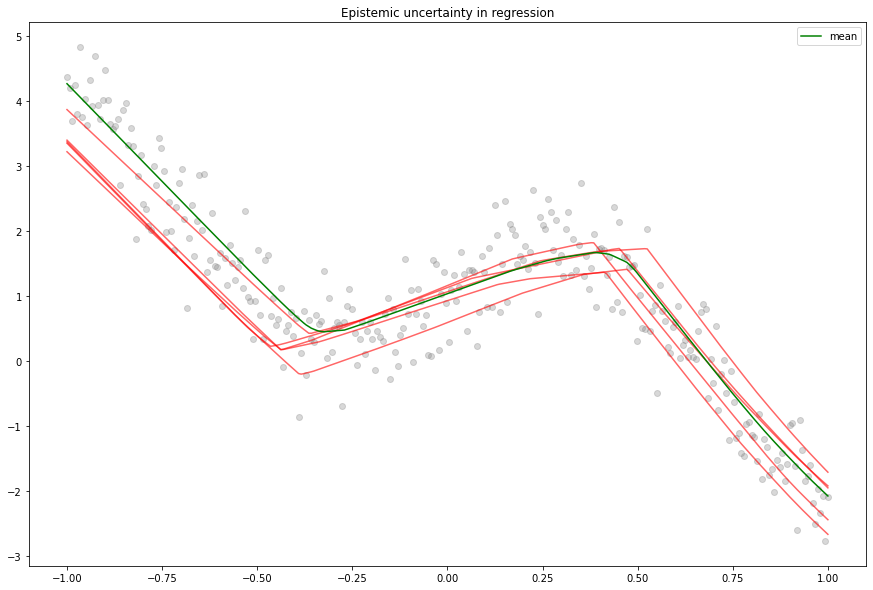

In [218]:
plt.figure(figsize=(15, 10))
plt.scatter(X, y, marker='o', color='gray', alpha=0.3)
y_pred = 0
for _ in range(5):
  y_pred +=  regressor(X)
  plt.plot(X, regressor(X), color='red', alpha=0.6)

plt.plot(X, y_pred/5, color='green', label='mean')
plt.legend()
plt.title('Epistemic uncertainty in regression')
plt.savefig('figs/epistemic_uncertainty_rgn.png')